In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os, sys

current_path = '/content/drive/My Drive/Colab Notebooks/Project_Stock/'

os.chdir(current_path)

Mounted at /content/drive


### **ARIMA**

In [2]:
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime


def arima_test(close, use_rows=None):

  size = int(len(close) * 0.66)
  train, test = close[0:size].values, close[size:len(close)]
  test_shift = test.shift(1).values
  test = test.values
  # break

  history = list(train)
  predictions = list()
  err_ranges = list()
  for t in range(len(test)):
    
      if use_rows is not None:
        history = history[-use_rows:]
        
      model = ARIMA(history, order=(0, 2, 1))
      model_fit = model.fit(trend='c', disp=0)
      output = model_fit.forecast()
      # print(output)
      # break
      yhat = output[0]
      predictions.append(yhat)
      err_ranges.append(output[1])
      obs = test[t]
      # print('obs :', obs)
      history.append(obs)
      # break
      print('\r %.2f%%' % (t / len(test) * 100), end='')

  print(len(test), len(predictions))

  return predictions, err_ranges


# print(high)


def get_back_result(ohlcv, predictions, err_ranges, tp=0.04, sl=None, leverage=1, show_detail=False, show_plot=False, return_pr=False, cumsum=False, 
                    close_ver=False, reverse_short=False):

  
  high, low, test = np.split(ohlcv.values[-len(predictions):, [1, 2, 3]], 3, axis=1)

  if close_ver:
    predictions = ohlcv['close'].shift(1).values[-len(test):]

  fee = 0.0006
  long_profits = []
  short_profits = []
  liquidations = []
  win_cnt = 0
  for i in range(len(test)):

    # long_ep = predictions[i]
    long_ep = (predictions[i] - err_ranges[i]) * (1 / (1 + tp))
    if sl is not None:
      long_sl = long_ep * (1 / (sl + 1))

    # assert long_ep < long_exit, 'long_exit < long_ep !, %s, %s' % (long_exit, long_ep)
    
    short_ep = (predictions[i] + err_ranges[i]) * (1 + tp)
    # short_ep = (predictions[i] + err_ranges[i]) * (1 / (1 - tp))
    if sl is not None:
      short_sl = short_ep * (1 / (1 - sl))

    # print((low[i]))

    #    long 우선   # <-- long & short 둘다 체결된 상황에서는 long 체결을 우선으로 한다.
    if low[i] < long_ep:
      
      liquidation = low[i] / long_ep - fee
      l_liquidation = 1 + (liquidation - 1) * leverage
      liquidations.append(l_liquidation)

      if max(l_liquidation, 0) == 0:
        l_profit = 0
        # print('low[i], long_ep, l_liquidation :', low[i], long_ep, l_liquidation)
      else:

        if sl is not None:
          if low[i] < long_sl:
            profit = long_sl / long_ep - fee
          else:
            profit = test[i] / long_ep - fee

        else:
          profit = test[i] / long_ep - fee

        l_profit = 1 + (profit - 1) * leverage
        l_profit = max(l_profit, 0)
        
        if profit >= 1:
          win_cnt += 1

      long_profits.append(l_profit)
      short_profits.append(1.0)

      if show_detail:
        print(test[i], predictions[i], long_ep)

    # if high[i] > short_ep > low[i]: # 지정 대기가 아니라, 해당 price 가 지나면, long 한다.

    #   if not reverse_short:
    #     liquidation = short_ep / high[i]  - fee
    #   else:
    #     liquidation = low[i] / short_ep  - fee
    #   l_liquidation = 1 + (liquidation - 1) * leverage

    #   if max(l_liquidation, 0) == 0:
    #     l_profit = 0
    #   else:

    #     if sl is not None:
    #       if high[i] > short_sl:

    #         if not reverse_short:
    #           profit = short_ep / short_sl - fee
    #         else:
    #           profit = short_sl / short_ep - fee

    #       else:
    #         if not reverse_short:
    #           profit = short_ep / test[i] - fee
    #         else:
    #           profit = test[i] / short_ep - fee

    #     else:

    #       if not reverse_short:
    #         profit = short_ep / test[i] - fee
    #       else:
    #         profit = test[i] / short_ep - fee

    #     l_profit = 1 + (profit - 1) * leverage
    #     l_profit = max(l_profit, 0)

    #     if profit >= 1:
    #       win_cnt += 1

    #   short_profits.append(l_profit)
    #   long_profits.append(1.0)

    #   if show_detail:
    #     print(test[i], predictions[i], short_ep)
    
    else:
      long_profits.append(1.0)
      short_profits.append(1.0)
      liquidations.append(1.0)


  long_win_ratio = sum(np.array(long_profits) > 1.0) / sum(np.array(long_profits) != 1.0)
  short_win_ratio = sum(np.array(short_profits) > 1.0) / sum(np.array(short_profits) != 1.0)
  long_frequency = sum(np.array(long_profits) != 1.0) / len(test)
  short_frequency = sum(np.array(short_profits) != 1.0) / len(test)
  if not cumsum:
    long_accum_profit = np.array(long_profits).cumprod()
    short_accum_profit = np.array(short_profits).cumprod()
  else:
    long_accum_profit = (np.array(long_profits) - 1.0).cumsum()
    short_accum_profit = (np.array(short_profits) - 1.0).cumsum()

  # print(win_ratio)

  if show_plot:

    plt.figure(figsize=(10, 5))
    plt.suptitle('tp=%.4f, lvrg=%d' % (tp, leverage))

    plt.subplot(151)
    plt.plot(liquidations)
    plt.title('liquidations')

    plt.subplot(152)
    plt.plot(long_profits)
    plt.title('Win Ratio : %.2f %%\nrequency : %.2f %%' % (long_win_ratio * 100, long_frequency * 100), color='black')
    # plt.show()

    # print()
    plt.subplot(153)
    plt.plot(long_accum_profit)
    plt.title('Accum_profit : %.2f' % long_accum_profit[-1], color='black')

    plt.subplot(154)
    plt.plot(short_profits)
    plt.title('Win Ratio : %.2f %%\nrequency : %.2f %%' % (short_win_ratio * 100, short_frequency * 100), color='black')
    # plt.show()

    # print()
    plt.subplot(155)
    plt.plot(short_accum_profit)
    plt.title('Accum_profit : %.2f' % short_accum_profit[-1], color='black')
    plt.show()

  return [long_win_ratio, short_win_ratio], [long_frequency, short_frequency], [long_accum_profit[-1], short_accum_profit[-1]], [long_profits, short_profits]



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

interval = '30m'
date_path = './candlestick_concated/%s/' % interval
file_list = os.listdir(date_path)

print((file_list))

['old', '2021-03-02 DOTUSDT.xlsx', '2021-02-11', '2021-04-08', 'ETHUSDT_ma7_close_entry_ai_plus.xlsx', 'NEOUSDT_ma7_close_entry_ai_plus.xlsx', '2021-04-27_non_stacked', '2021-04-27', 'ETHUSDT_ai_plus.xlsx']


### **Keep connection**

In [ ]:
while 1 : 1

### **Model tester**

len(ohlcv) : 3002
-------------- ETHUSDT_ai_plus.xlsx --------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:157: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different 

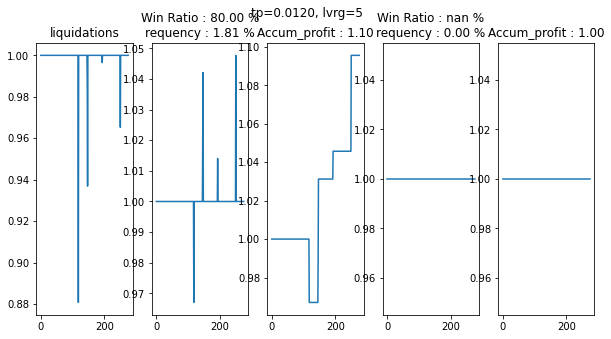

len(ohlc) : 276
long_ep.shape : (276, 1)
len(pr_list) : 276
np.array(data_x).shape : (5, 45, 6)
input_x.shape : (5, 45, 6, 3)
input_x.dtype : float32
input_pr.shape : (5, 1)
input_ud.shape : (5, 1)
origin ac_pr : 1.0956274
win ratio improvement 0.80 --> 0.67


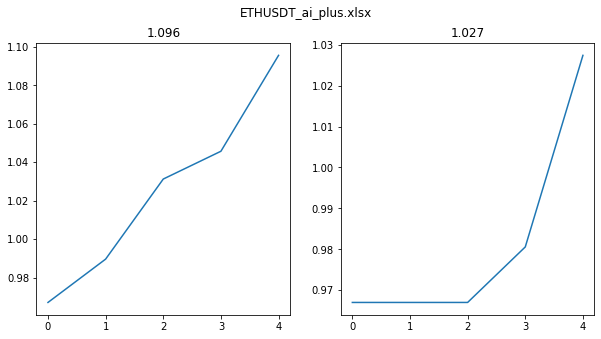

In [6]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
import keras
from sklearn.metrics import confusion_matrix
import pickle


ckpt_path = current_path + 'ckpt/'

model_name = 'classifier_45_ai_pr_0211_014026.h5'
# model_name = 'classifier_45_arima_close_updown_pr_05372.h5'
model = keras.models.load_model(ckpt_path + model_name)

long_index = 0
leverage = 5
thresh = 0.2614

candis = ["ETHUSDT_ai_plus.xlsx"]
prev_x = None
for i in range(len(candis)):


  keys = [candis[i]]


  for key in keys:  
    # print(profit_result_dict[key]['leverage_ap_list'])

    # for tp in [max_peak_tp]:

      # if tp == peak_tp:
      #   plt.subplot(1,10,5)
      # else:
      #   plt.subplot(1,10,6)

      #     leverage analysis     #
      ohlcv = pd.read_excel(date_path + key, index_col=0)
      print('len(ohlcv) :', len(ohlcv))

      ohlcv = ohlcv.iloc[np.sum(np.isnan(ohlcv['ep'].values)):]
      # ohlcv = ohlcv.iloc[-int(len(ohlcv) * 0.34):]
      predictions = ohlcv['ep']
      err_ranges = np.zeros_like(predictions)

      # predictions = ohlcv['close'].shift(1).values
      # err_ranges = np.zeros_like(predictions)

      # leverage_list = profit_result_dict[key]['leverage_list']
      # temp_ap_list = list()
      # temp_pr_list = list()

      try:
        print('-------------- %s --------------' % key)
        result = get_back_result(ohlcv, predictions, err_ranges, tp=0.012, leverage=leverage, show_plot=True, reverse_short=False, show_detail=False)
        # temp_ap_list.append(result[2])
        # temp_pr_list.append(result[3])

        # if round(leverage) == 1:
        #   temp_pr_list = result[3]
        pr_list = result[3][long_index]

      except Exception as e:
        print(e)
        break    
  # break


      pd.set_option('display.max_rows', 500)
      pd.set_option('display.max_columns', 500)
      pd.set_option('display.width', 1000)

      #         clustering zone           #

      #       set data features : ohlc, v, ep
      ohlc = ohlcv.iloc[-len(predictions):, :4]
      vol = ohlcv.iloc[-len(predictions):, [4]]
      long_ep = np.array(predictions)
      # long_ep = ohlc.iloc[:, [-1]].values <-- 이건 이전 종가가 아니라 그냥 종가임
      long_ep = long_ep.reshape(-1, 1)

      ohlcv['u_wick'] = ohlcv['high'] / np.maximum(ohlcv['close'] , ohlcv['open'])
      ohlcv['d_wick'] = np.minimum(ohlcv['close'] , ohlcv['open']) / ohlcv['low']
      ohlcv['body'] = ohlcv['close'] / ohlcv['open']

      candle = ohlcv.iloc[-len(predictions):, -3:]


      print('len(ohlc) :', len(ohlc))
      print('long_ep.shape :', long_ep.shape)
      print('len(pr_list) :', len(pr_list))


      #       set params    #
      period = 45
      data_x, data_pr, data_updown = [], [], []
      key_i = i

      for i in range(period, len(predictions)):

        #   pr_list != 1 인 데이터만 사용한다
        # if 1:
        if pr_list[i] != 1:
          
          #   prediction 을 제외한 이전 데이터를 사용해야한다
          temp_ohlc = ohlc.iloc[i - period : i].values
          temp_long_ep = long_ep[i - period : i]
          temp_vol = vol.iloc[i - period : i].values
          temp_candle = candle.iloc[i - period : i].values

          # print(temp_ohlc.shape)
          # print(temp_long_ep.shape)
          # print(temp_vol.shape)
          # print(temp_candle.shape)
          # break

          #   stacking  
          # temp_data = np.hstack((temp_ohlc, temp_long_ep, temp_vol, temp_candle))
          temp_data = np.hstack((temp_ohlc, temp_long_ep, temp_vol))
          # temp_data = np.hstack((temp_ohlc, temp_vol))

          # temp_data = np.hstack((temp_ohlc, temp_long_ep))
          # temp_data = temp_vol

          #   scaler 설정

          #   ohlc & ep -> max_abs
          # max_abs = MaxAbsScaler()
          # temp_data[:, :5] = max_abs.fit_transform(temp_data[:, :5])


          min_max = MinMaxScaler()
          temp_data[:, :5] = min_max.fit_transform(temp_data[:, :5])


          #   vol -> min_max
          min_max = MinMaxScaler()
          temp_data[:, [5]] = min_max.fit_transform(temp_data[:, [5]])


          #   candle -> max_abs    
          # max_abs = MaxAbsScaler()
          # temp_data[:, -3:] = max_abs.fit_transform(temp_data[:, -3:])

          # min_max = MinMaxScaler()
          # temp_data[:, -3:] = min_max.fit_transform(temp_data[:, -3:])

          if np.isnan(np.sum(temp_data)):
            continue

          data_x.append(temp_data)
          data_pr.append(pr_list[i])
          data_updown.append(ohlc['close'].iloc[i] / ohlc['open'].iloc[i])


      print('np.array(data_x).shape :', np.array(data_x).shape)
      # print(data_x[0])


      #       Reshape data for image deep - learning     #
      _, row, col = np.array(data_x).shape

      input_x = np.array(data_x).reshape(-1, row, col, 1).astype(np.float32)

      #     1c to 3c    #
      input_x = input_x * np.ones(3, dtype=np.float32)[None, None, None, :]

      input_pr = np.array(data_pr).reshape(-1, 1).astype(np.float32)
      input_ud = np.array(data_updown).reshape(-1, 1).astype(np.float32)
      print('input_x.shape :', input_x.shape)
      print('input_x.dtype :', input_x.dtype)
      print('input_pr.shape :', input_pr.shape)
      print('input_ud.shape :', input_ud.shape)


      #         reshape data     #
      temp_x = list()
      for d_i, data in enumerate(input_x):
        # resized_data = cv2.resize(data, (row * 2, col * 2)) --> input image 홰손된다
        resized_data = data.repeat(2, axis=0).repeat(2, axis=1)
        # cmapped = plt.cm.Set1(resized_data)[:, :, :3]  # Drop Alpha Channel
        
        # if d_i == 0:
        #   plt.imshow(data)
        #   plt.show()
        #   plt.imshow(resized_data)
        #   plt.show()
        # print('resized_data.shape :', resized_data.shape)
        # break
        temp_x.append(resized_data)

      re_input_x = np.array(temp_x)
      y_test = np.where(input_pr > 1, 1, 0)
      # y_test = np.where(input_ud > 1, 1, 0)

      #             ai tester phase              #
      test_result = model.predict(re_input_x)
      
      y_score = test_result[:, [1]]
      y_pred = np.where(y_score[:, -1] > thresh, 1, 0)


      
      #         plot result       #
      test_size = len(y_test)
      test_pr_list = input_pr
      print('origin ac_pr :', np.cumprod(test_pr_list)[-1])

      
      cmat = confusion_matrix(y_test, y_pred)

      org_wr = np.sum(cmat, axis=1)[-1] / sum(np.sum(cmat, axis=1))
      ml_wr = cmat[1][1] / np.sum(cmat, axis=0)[-1]
      print('win ratio improvement %.2f --> %.2f' % (org_wr, ml_wr))

      # print('pr_test.shape :', pr_test.shape)

      # print(y_pred)
      # print(test_pr_list)
      pred_pr_list = np.where(y_pred == 1, test_pr_list.reshape(-1, ), 1.0)
      # print('pred_pr_list.shape :', pred_pr_list.shape)

      if np.cumprod(test_pr_list)[-1] < np.cumprod(pred_pr_list)[-1]:
        print('accum_pr increased ! : %.3f --> %.3f' % (np.cumprod(test_pr_list)[-1], np.cumprod(pred_pr_list)[-1]))
        print('thresh :', thresh)
        
      # if len(threshold) == 1:
      plt.figure(figsize=(10, 5))

      plt.suptitle(key)
      plt.subplot(121)
      plt.plot(np.cumprod(test_pr_list))
      plt.title('%.3f' % (np.cumprod(test_pr_list)[-1]))
    # plt.show()

      plt.subplot(122)
      plt.plot(np.cumprod(pred_pr_list))
      plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
      plt.show()

#     save acc_pr result for comparing pairs --> find best pair   #
      #     save improved win_ratio, acc_pr   #
      # temp_dict = load_dict[key]
      # temp_dict['improved_wr'] = ml_wr
      # temp_dict['improved_ap_list'] = np.cumprod(pred_pr_list)


      # #         save dict       #
      # with open('./arima_result/arima_arima_close_updown_profit_ls_only_long_result_%s.pickle' % interval, 'wb') as f:
      #   pickle.dump(load_dict, f)


      #     do stacking   #
      # if prev_x is None:
      #   prev_x = input_x
      #   prev_pr = input_pr
      #   prev_ud = input_ud
      # else:
      #   total_x = np.vstack((prev_x, input_x))
      #   total_pr = np.vstack((prev_pr, input_pr))
      #   total_ud = np.vstack((prev_ud, input_ud))

      #   prev_x = total_x
      #   prev_pr = total_pr
      #   prev_ud = total_ud

      #   print('total_x.shape :', total_x.shape)
      #   print('total_pr.shape :', total_pr.shape)
      #   print('total_ud.shape :', total_ud.shape)
        

In [ ]:
with open('./arima_result/arima_arima_close_updown_profit_ls_only_long_result_%s.pickle' % interval, 'rb') as f:
  pair_comp_dict = pickle.load(f)

total_pair_list, total_wr_list, total_pr_list = [], [], []

keys = list(pair_comp_dict.keys())
for key in keys:

  if '04-08' in key:
    total_pair_list.append(key)
    total_wr_list.append(pair_comp_dict[key]['improved_wr'])
    total_pr_list.append(pair_comp_dict[key]['improved_ap_list'][-1])
    
    
result_df = pd.DataFrame(index=total_pair_list)


# result_df['index'] = pairs
result_df['improved_wr'] = total_wr_list
result_df['improved_ap_list']= total_pr_list
# print(result_df)

#     sort by values    #
print(result_df.sort_values(by='improved_wr', ascending=False))
print(result_df.sort_values(by='improved_ap_list', ascending=False))

#     extract candidates    #
# candis = result_df.sort_values(by=['max_lv_profit'], ascending=False).index

                           improved_wr  improved_ap_list
2021-04-08 ETHUSDT.xlsx       0.872433      1.137917e+19
2021-04-08 LTCUSDT.xlsx       0.861650      1.524078e+22
2021-04-08 ETCUSDT.xlsx       0.848393      3.452545e+19
2021-04-08 BCHUSDT.xlsx       0.844486      6.654607e+18
2021-04-08 EOSUSDT.xlsx       0.843038      4.436721e+18
2021-04-08 LINKUSDT.xlsx      0.833650      1.757980e+21
2021-04-08 BTCUSDT.xlsx       0.814557      2.257411e+13
2021-04-08 XLMUSDT.xlsx       0.809170      8.338974e+20
2021-04-08 NEOUSDT.xlsx       0.797386      2.960085e+11
2021-04-08 ADAUSDT.xlsx       0.795306      6.044627e+19
2021-04-08 XRPUSDT.xlsx       0.784718      9.614129e+16
2021-04-08 XMRUSDT.xlsx       0.773282      1.470935e+13
2021-04-08 OMGUSDT.xlsx       0.772080      1.932528e+09
2021-04-08 QTUMUSDT.xlsx      0.770936      4.451637e+09
2021-04-08 DASHUSDT.xlsx      0.758140      4.472870e+08
2021-04-08 XTZUSDT.xlsx       0.753757      5.114877e+09
2021-04-08 ONTUSDT.xlsx       0

### **Model**

In [ ]:
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

%tensorflow_version 1.x

import keras
import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.misc 
from math import sqrt 
import itertools
from IPython.display import display

%matplotlib inline

from keras.utils import plot_model
import keras.backend as K
from keras.models import Model, Sequential
import keras.layers as layers
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


gdrive_path = current_path

num_classes = 2

def FER_Model(input_shape=(row, col, 3)):
    # first input model
    visible = layers.Input(shape=input_shape, name='input')
    
    net = layers.Conv2D(32, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(visible)
    # net = layers.BatchNormalization()(net)
    net = layers.LeakyReLU()(net)

    net = layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.BatchNormalization()(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    # net = layers.MaxPool2D(pool_size=2)(net)
    # net = layers.AveragePooling2D(padding='same')(net)

    shortcut_1 = net

    # net = layers.Conv2D(64, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    net = layers.Conv2D(128, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    net = layers.LeakyReLU()(net)

    net = layers.Conv2D(256, kernel_size=3, padding='same', kernel_initializer='he_normal')(net)
    # net = layers.BatchNormalization()(net)
    # net = layers.Activation('relu')(net)
    net = layers.LeakyReLU()(net)
    # net = layers.MaxPool2D(pool_size=2)(net)

    shortcut_2 = net

#     net = layers.Conv2D(256, kernel_size=3, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

#     shortcut_3 = net

#     net = layers.Conv2D(128, kernel_size=1, padding='same')(net)
#     # net = layers.Activation('relu')(net)
#     net = layers.LeakyReLU()(net)
#     net = layers.MaxPool2D(pool_size=2)(net)

    net = layers.Flatten()(net)
    net = layers.Dense(128)(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(64)(net)
    net = layers.LeakyReLU()(net)

    net = layers.Dense(num_classes, activation='softmax')(net)

    # create model 
    model = Model(inputs=visible, outputs=net)
    # summary layers
    # print(model.summary())
    
    return model

TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
keras.__version__
tf.__version__

'2.4.1'

### **Data Split**

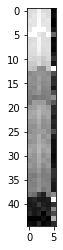

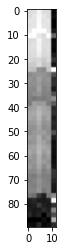

re_total_x.shape : (173568, 90, 12, 3)
pr_train[:5] : [[1.0393989]
 [1.055382 ]
 [1.0241528]
 [1.016777 ]
 [0.9873842]]
ud_train[:5] : [[1.0089116 ]
 [1.0118363 ]
 [1.0052873 ]
 [1.0046616 ]
 [0.99625933]]
y_train[:5] : [[1]
 [1]
 [1]
 [1]
 [0]]
y_train.dtype : int64
x_train.shape : (104140, 90, 12, 3)
x_test.shape : (34714, 90, 12, 3)
x_val.shape : (34714, 90, 12, 3)
y_train.shape : (104140, 1)
y_test.shape : (34714, 1)
y_val.shape : (34714, 1)
np.unique(y_train, return_counts=True : (array([0, 1]), array([55570, 48570])) [1.14412189 1.        ]
np.unique(y_val, return_counts=True : (array([0, 1]), array([18413, 16301])) [1.1295626 1.       ]
np.unique(y_test, return_counts=True : (array([0, 1]), array([18566, 16148])) [1.14973991 1.        ]
class_weights : {0: 0.937016375742307, 1: 1.0720609429689107}
np.isnan(np.sum(x_train)) : False
np.isnan(np.sum(x_val)) : False
np.isnan(np.sum(x_test)) : False
np.isnan(np.sum(y_train)) : False
np.isnan(np.sum(y_val)) : False
np.isnan(np.sum(y_t

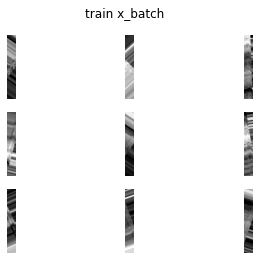

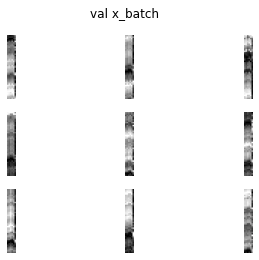

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.utils import class_weight
# import cv2



seed = 1
random_state = 20
np.random.seed(seed)
# tf.random.set_seed(seed)

#         resize total_x shape  (, 5, 6, 3)      #
# .repeat(2, axis=0).repeat(2, axis=1)
temp_x = list()
for d_i, data in enumerate(total_x):
  # resized_data = cv2.resize(data, (row * 2, col * 2)) --> input image 홰손된다
  resized_data = data.repeat(2, axis=0).repeat(2, axis=1)
  # cmapped = plt.cm.Set1(resized_data)[:, :, :3]  # Drop Alpha Channel
  
  if d_i == 0:
    plt.imshow(data)
    plt.show()
    plt.imshow(resized_data)
    plt.show()
  # print('resized_data.shape :', resized_data.shape)
  # break
  temp_x.append(resized_data)

re_total_x = np.array(temp_x)
print('re_total_x.shape :', re_total_x.shape)
# break

#         train / test split      #
x_train, x_test_, pr_train, pr_test_, ud_train, ud_test_ = train_test_split(re_total_x, total_pr, total_ud, test_size=0.4, shuffle=True, random_state=random_state)
x_test, x_val, pr_test, pr_val, ud_test, ud_val = train_test_split(x_test_, pr_test_, ud_test_, test_size=0.5, shuffle=True, random_state=random_state)


#         pr label   #
y_train = np.where(pr_train > 1, 1, 0)
y_test = np.where(pr_test > 1, 1, 0)
y_val = np.where(pr_val > 1, 1, 0)

#         up label      #
# y_train = np.where(ud_train > 1, 1, 0)
# y_test = np.where(ud_test > 1, 1, 0)
# y_val = np.where(ud_val > 1, 1, 0)

print('pr_train[:5] :', pr_train[:5])
print('ud_train[:5] :', ud_train[:5])
print('y_train[:5] :', y_train[:5])
print('y_train.dtype :', y_train.dtype)

print('x_train.shape :', x_train.shape)
print('x_test.shape :', x_test.shape)
print('x_val.shape :', x_val.shape)
print('y_train.shape :', y_train.shape)
print('y_test.shape :', y_test.shape)
print('y_val.shape :', y_val.shape)

def class_ratio(in_list):

  return in_list / in_list[1]

print('np.unique(y_train, return_counts=True :', np.unique(y_train, return_counts=True), class_ratio(np.unique(y_train, return_counts=True)[1]))
print('np.unique(y_val, return_counts=True :', np.unique(y_val, return_counts=True), class_ratio(np.unique(y_val, return_counts=True)[1]))
print('np.unique(y_test, return_counts=True :', np.unique(y_test, return_counts=True), class_ratio(np.unique(y_test, return_counts=True)[1]))

label = y_train.reshape(-1, )
class_weights = class_weight.compute_class_weight('balanced', 
                                                    classes=np.unique(label),
                                                    y=label)
class_weights = dict(enumerate(class_weights))
print('class_weights :', class_weights)

# sample_weight = np.ones(shape=(len(y_train),))
# sample_weight[(y_train == 1).reshape(-1,)] = 1.5
# print('sample_weight[:20] :', sample_weight[:20])


print('np.isnan(np.sum(x_train)) :', np.isnan(np.sum(x_train)))
print('np.isnan(np.sum(x_val)) :', np.isnan(np.sum(x_val)))
print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))

print('np.isnan(np.sum(y_train)) :', np.isnan(np.sum(y_train)))
print('np.isnan(np.sum(y_val)) :', np.isnan(np.sum(y_val)))
print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

y_train_ohe = np_utils.to_categorical(y_train, num_classes)
y_val_ohe = np_utils.to_categorical(y_val, num_classes)
y_test_ohe = np_utils.to_categorical(y_test, num_classes)
print('y_train_ohe.shape :', y_train_ohe.shape)
print('y_val_ohe.shape :', y_val_ohe.shape)
print('y_test_ohe.shape :', y_test_ohe.shape)

datagen = ImageDataGenerator( 
    rotation_range = 45,
    # zoom_range = 0.5,
    # shear_range = 0.5,
    # horizontal_flip = True,
    # vertical_flip = True,
    # width_shift_range=0.5,
    # height_shift_range=0.5,
    # fill_mode = 'nearest'
    )

valgen = ImageDataGenerator( 
    )

datagen.fit(x_train)
valgen.fit(x_val)

batch_size = 256

for x_batch, _ in datagen.flow(x_train, y_train_ohe, batch_size=9):

    plt.suptitle("train x_batch")

    for i in range(0, 9): 
        plt.subplot(330 + 1 + i) 
        # resized = cv2.resize(x_batch[i].reshape(row, col), (row * 2, col * 10))
        # cmapped = plt.cm.Set1(resized)
        # plt.imshow(cmapped)
        # plt.imshow(x_batch[i].reshape(row, col))
        plt.imshow(x_batch[i])
        plt.axis('off') 
    plt.show() 
    break

for x_batch, _ in valgen.flow(x_val, y_val_ohe, batch_size=9):

    plt.suptitle("val x_batch")

    for i in range(0, 9): 
        plt.subplot(330 + 1 + i) 
        # resized = cv2.resize(x_batch[i].reshape(row, col), (row * 2, col * 10))
        # cmapped = plt.cm.Set1(resized)
        # plt.imshow(cmapped)
        # plt.imshow(x_batch[i].reshape(row, col))
        plt.imshow(x_batch[i])
        plt.axis('off') 
    plt.show() 
    break
    
train_flow = datagen.flow(x_train, y_train_ohe, batch_size=batch_size) 
val_flow = valgen.flow(x_val, y_val_ohe, batch_size=batch_size) 
# break



### **Training**

In [ ]:
(_, row, col, _) = x_train.shape

model = FER_Model(input_shape=(row, col, 3))
opt = Adam(lr=0.00001, decay=0.000005)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

ckpt_path = current_path + 'ckpt/'
board_path = current_path + 'graph/'
model_name = 'classifier_%s_min_pr_re2.h5' % period

checkpoint = ModelCheckpoint(ckpt_path + model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
checkpoint2 = TensorBoard(log_dir=board_path,
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
checkpoint3 = EarlyStopping(monitor='val_loss', patience=30)
callbacks_list = [checkpoint, checkpoint2, checkpoint3]

# keras.callbacks.Callback 로 부터 log 를 받아와 history log 를 작성할 수 있다.

# we iterate 200 times over the entire training set
num_epochs = 300
history = model.fit_generator(train_flow, 
                    steps_per_epoch=len(x_train) / batch_size, 
                    epochs=num_epochs,  
                    verbose=2,  
                    callbacks=callbacks_list,
                    class_weight=class_weights,
                    validation_data=val_flow,  
                    validation_steps=len(x_val) / batch_size,
                    shuffle=False)

In [ ]:
ckpt_path = current_path + 'ckpt/'
model_name = 'classifier_%s_arima_close_updown_pr_05510.h5' % period
model = keras.models.load_model(ckpt_path + model_name)

test_result.shape : (34714, 2)
pr_val.shape : (34714, 1)
y_test[:5] : [0 0 1 0 0]
y_score[:5] : [[0.32349682]
 [0.28463694]
 [0.62112874]
 [0.15904172]
 [0.15600081]]
y_test.shape : (34714, 1)
y_score.shape : (34714, 1)
len(y_test) : 34714


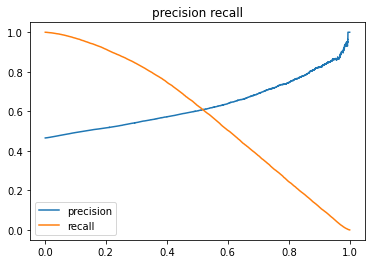

Streaming output truncated to the last 5000 lines.
accum_pr increased ! : 0.000 --> 4895759872.000
thresh : 0.97089976
y_pred.shape : (34714,)
precision : 0.8898678414096917
recall : 0.02501857815209314

np.isnan(np.sum(x_test)) : False
np.isnan(np.sum(y_test)) : False

origin ac_pr : 0.0
win ratio improvement 0.47 --> 0.89
accum_pr increased ! : 0.000 --> 4543150592.000
thresh : 0.9709405
y_pred.shape : (34714,)
precision : 0.8896247240618101
recall : 0.024956650978449343

np.isnan(np.sum(x_test)) : False
np.isnan(np.sum(y_test)) : False

origin ac_pr : 0.0
win ratio improvement 0.47 --> 0.89
accum_pr increased ! : 0.000 --> 4491607040.000
thresh : 0.97094065
y_pred.shape : (34714,)
precision : 0.8893805309734514
recall : 0.02489472380480555

np.isnan(np.sum(x_test)) : False
np.isnan(np.sum(y_test)) : False

origin ac_pr : 0.0
win ratio improvement 0.47 --> 0.89
accum_pr increased ! : 0.000 --> 4314691584.000
thresh : 0.9709637
y_pred.shape : (34714,)
precision : 0.8891352549889135
re

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in long_scalars


np.isnan(np.sum(x_test)) : False
np.isnan(np.sum(y_test)) : False

origin ac_pr : 0.0
win ratio improvement 0.47 --> nan
accum_pr increased ! : 0.000 --> 1.000
thresh : 0.9997129
acc_pr_bythr : [34603.6, 34603.758, 34603.8, 34603.805, 34603.992, 34604.027, 34604.082, 34604.12, 34604.203, 34604.3, 34604.32, 34604.414, 34604.434, 34604.348, 34604.36, 34604.383, 34604.457, 34604.586, 34604.605, 34604.625, 34604.68, 34604.723, 34604.8, 34604.87, 34604.977, 34605.09, 34605.113, 34605.133, 34605.273, 34605.402, 34605.402, 34605.535, 34605.63, 34605.652, 34605.707, 34605.746, 34605.742, 34605.832, 34605.848, 34605.92, 34605.984, 34605.973, 34606.027, 34606.03, 34606.027, 34606.04, 34606.07, 34606.133, 34606.223, 34606.195, 34606.223, 34606.31, 34606.375, 34606.395, 34606.473, 34606.496, 34606.52, 34606.555, 34606.492, 34606.59, 34606.61, 34606.664, 34606.688, 34606.715, 34606.758, 34606.77, 34606.812, 34606.977, 34607.06, 34607.09, 34607.24, 34607.18, 34607.293, 34607.32, 34607.42, 34607.434,

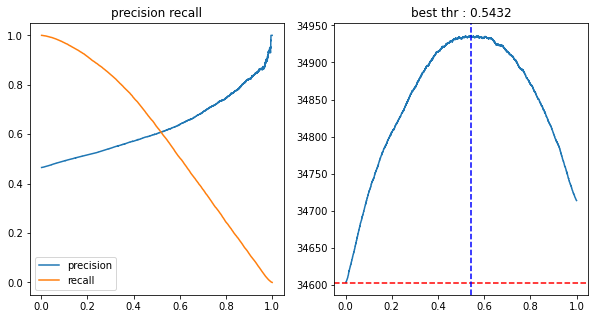

In [ ]:
test_result = model.predict(x_test)
# test_result = model.predict(test_set)

print('test_result.shape :', test_result.shape)
print('pr_val.shape :', pr_val.shape)

y_score = test_result[:, [1]]

print('y_test[:5] :', y_test.reshape(-1,)[:5])
# print('np.unique(y_test) :', np.unique(y_test, return_counts=True))
print('y_score[:5] :', y_score[:5])
# print('np.unique(y_score) :', np.unique(y_score, return_counts=True))

print('y_test.shape :', y_test.shape)
print('y_score.shape :', y_score.shape)

print('len(y_test) :', len(y_test))

#     precision recall curve   #
precision, recall, threshold = precision_recall_curve(y_test, y_score)
precision, recall = precision[:-1], recall[:-1]

plt.plot(threshold, precision, label='precision')
plt.plot(threshold, recall, label='recall')
plt.legend()
plt.title('precision recall')
plt.show()
# print(y_pred)

# thresh = 0.19
# threshold = [thresh]
print('threshold :', threshold)

acc_pr_bythr = []
for thresh in threshold:

  y_pred = np.where(y_score[:, -1] > thresh, 1, 0)
  print('y_pred.shape :', y_pred.shape)
  # print('y_pred :', y_pred)

  #     compare precision     #

  print('precision :', precision_score(y_test, y_pred))
  print('recall :', recall_score(y_test, y_pred))
  print()

  print('np.isnan(np.sum(x_test)) :', np.isnan(np.sum(x_test)))
  print('np.isnan(np.sum(y_test)) :', np.isnan(np.sum(y_test)))

  # plot_confusion_matrix(best_model, x_test, y_test, normalize=None)
  # plt.show()  
  print()

  #     check win-ratio improvement     #
  cmat = confusion_matrix(y_test, y_pred)
  # print(cmat)
  # print(np.sum(cmat, axis=1))

  test_size = len(y_test)
  test_pr_list = pr_test
  print('origin ac_pr :', np.cumprod(test_pr_list)[-1])

  org_wr = np.sum(cmat, axis=1)[-1] / sum(np.sum(cmat, axis=1))
  ml_wr = cmat[1][1] / np.sum(cmat, axis=0)[-1]
  print('win ratio improvement %.2f --> %.2f' % (org_wr, ml_wr))

  # print('pr_test.shape :', pr_test.shape)

  # print(y_pred)
  # print(test_pr_list)
  pred_pr_list = np.where(y_pred == 1, test_pr_list.reshape(-1, ), 1.0)
  # print('pred_pr_list.shape :', pred_pr_list.shape)

  if np.cumprod(test_pr_list)[-1] < np.cumprod(pred_pr_list)[-1]:
    print('accum_pr increased ! : %.3f --> %.3f' % (np.cumprod(test_pr_list)[-1], np.cumprod(pred_pr_list)[-1]))
    print('thresh :', thresh)
    
  # if len(threshold) == 1:
  #   plt.figure(figsize=(10, 5))
  #   plt.subplot(121)
  #   plt.plot(np.cumprod(test_pr_list))
  #   plt.title('%.3f' % (np.cumprod(test_pr_list)[-1]))
  # # plt.show()

  #   plt.subplot(122)
  #   plt.plot(np.cumprod(pred_pr_list))
  #   plt.title('%.3f' % (np.cumprod(pred_pr_list)[-1]))
  #   plt.show()


  acc_pr_bythr.append(np.cumsum(pred_pr_list)[-1])

print('acc_pr_bythr :', acc_pr_bythr)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(threshold, precision, label='precision')
plt.plot(threshold, recall, label='recall')
plt.legend()
plt.title('precision recall')
# plt.show()
plt.subplot(122)
plt.plot(threshold, acc_pr_bythr)
plt.axhline(np.cumsum(test_pr_list)[-1], linestyle='--', color='r')
plt.axvline(threshold[np.argmax(acc_pr_bythr)], linestyle='--', color='b')
plt.title('best thr : %.4f' % threshold[np.argmax(acc_pr_bythr)])
plt.show()

#### **clustering output**

[[0.36982605 0.6301739 ]
 [0.07175738 0.92824256]
 [0.80384654 0.19615342]
 [0.36580992 0.63419   ]
 [0.62421626 0.37578377]
 [0.5436404  0.4563596 ]
 [0.52329445 0.47670558]
 [0.97153586 0.02846407]
 [0.09378401 0.906216  ]
 [0.5878242  0.41217574]]
x_train_for_k.shape : (1002, 2)
pr_train.shape : (1002, 1)


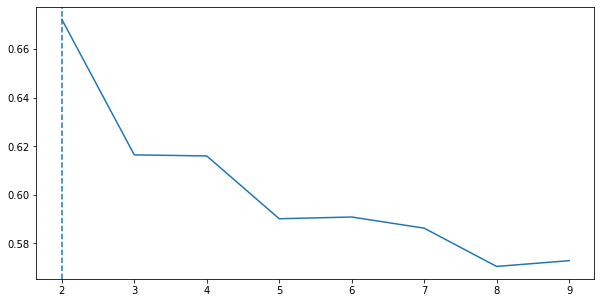

-45.123154
1002 1002
{0: [], 1: []}
{0: [1.0112358, 1.0108912, 1.0418938, 1.0177829, 0.93396086, 0.9884052, 0.99886274, 1.0022553, 1.0436578, 0.9207443, 0.9955782, 1.0021976, 0.9766896, 1.0035869, 0.931786, 0.98704076, 0.96317285, 1.0219475, 1.0056812, 1.0091392, 0.98483473, 1.0248575, 1.0039655, 0.9989848, 0.97611266, 1.0031642, 0.99072725, 1.0110428, 1.0012652, 0.98009694, 0.98891103, 1.001031, 0.9925284, 0.98300475, 0.9173347, 0.9817562, 1.0159234, 0.9987753, 1.0199425, 0.99830467, 0.99935544, 0.9719168, 0.8895108, 0.990376, 0.9574259, 1.0298535, 0.9856985, 0.9992266, 0.97316617, 0.9612815, 0.99626565, 0.9191523, 0.9997985, 0.97651285, 0.964942, 1.021349, 1.0139021, 0.96651024, 1.0361159, 1.0376519, 1.0156211, 0.9252124, 1.0025837, 1.0513692, 1.0082949, 0.9888693, 0.98879564, 1.0066702, 0.98474336, 0.9919862, 1.0004059, 0.9952053, 0.9122916, 0.97149587, 0.8537788, 0.96345854, 1.0977477, 1.019328, 0.997692, 0.98987234, 1.0165578, 1.0443726, 1.0130826, 1.0296476, 1.0019435, 1.0056043,

In [ ]:
# x_train_for_k = test_result.flatten().reshape(-1, 1)
x_train_for_k = test_result
print(x_train_for_k[:10])
# x_train_for_k = test_result[:, [1]]
pr_train = pr_test

print('x_train_for_k.shape :', x_train_for_k.shape)
print('pr_train.shape :', pr_train.shape)

K = range(2, 10)
s_dist = []
sil = []
for k in K:
  # if cen_data.shape[0] < k:
  #   break

  km = KMeans(n_clusters=k)
  km = km.fit(x_train_for_k)

  labels = km.labels_
  # print('len(labels) :', len(labels))
  # print('labels[:10] :', labels[:10])
  sil.append(silhouette_score(x_train_for_k, labels, metric='euclidean'))

  # inertia = km.inertia_
  # s_dist.append(inertia)

best_k = K[np.argmax(np.array(sil))]

plt.figure(figsize=(10, 5))
plt.plot(K, sil)
plt.axvline(best_k, linestyle='--')
# plt.plot(K, s_dist)
plt.show()





#   with best_k, label 별 pr_list 확인
km = KMeans(n_clusters=best_k)
km = km.fit(x_train_for_k)

labels = km.labels_

print(km.score(x_train_for_k))
print(len(labels), len(pr_train))





#   label 별로 profit 을 저장, 승률을 확인한다
label_types = np.unique(labels, return_counts=False)

label_pr_dict = {}
#   init dict   #
for label in label_types:
  label_pr_dict[label] = []
print(label_pr_dict)
# break

for i, (label, pr) in enumerate(zip(labels, pr_train)):
  label_pr_dict[label].append(pr[0])

  
# for label in label_types:
print(label_pr_dict)





def win_ratio(list_x):

  win_cnt = np.sum(np.array(list_x) > 1)
  return win_cnt / len(list_x)


def acc_pr(list_x):

  return np.cumprod(np.array(list_x))[-1]


for key in label_pr_dict:
  
  print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))





#     predict test && test 의 라벨에 따른 win_ratio 확인
# test_labels = km.predict(x_test)
# # print(test_labels)

# label_pr_dict = {}
# #   init dict   #
# for label in label_types:
#   label_pr_dict[label] = []
# print(label_pr_dict)
# # break

# for i, (label, pr) in enumerate(zip(test_labels, pr_test)):
#   label_pr_dict[label].append(pr[0])

# for key in label_pr_dict:

#   print(key, ':', 'win_ratio : %.2f' % (win_ratio(label_pr_dict[key])), 'acc_pr : %.2f' % (acc_pr(label_pr_dict[key])))

